In [1]:
import os
import cv2
import struct
import shutil
import copy
import glob
import argparse
import trimesh
import numpy as np
import open3d as o3d
from tqdm import tqdm
from PIL import Image
import sys
sys.path.append('/workspace/gim_3d/')
from utils.colmap_utils import Colmap
from utils.depth_utils import *
import imageio

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
data_dir = '/workspace/advtex_init_align/dataset/scannet/scene0706_00'

In [3]:
K = np.loadtxt(os.path.join(data_dir, "intrinsic/intrinsic_color.txt"))

In [14]:
colmap = Colmap()
cameras_txt = colmap.read_cameras_text('/workspace/advtex_init_align/dataset/goblet/cameras.txt')
images_txt = colmap.read_images_text('/workspace/advtex_init_align/dataset/goblet/images.txt')
intrinsics = colmap.get_intrinsics(cameras_txt)

1

In [13]:
intrinsics

{1: array([[1.34488179e+04, 0.00000000e+00, 3.43300000e+03],
        [0.00000000e+00, 1.34488179e+04, 2.28850000e+03],
        [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
 2: array([[1.3440857e+04, 0.0000000e+00, 3.4265000e+03],
        [0.0000000e+00, 1.3440857e+04, 2.2840000e+03],
        [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]])}

In [3]:
colmap = Colmap()
images_txt = colmap.read_images_text(os.path.join(args.path_to_colmap,'dense/sparse/images.txt'))
cameras_txt = load_colmap_camera(os.path.join(args.path_to_colmap,'dense/sparse/cameras.txt'))
extrinsics = colmap.read_keylog(args.path_to_keylog)


NameError: name 'args' is not defined

In [64]:
extrinsics = colmap.read_keylog('/workspace/advtex_init_align/dataset/east_underchurch/key.log')

In [66]:
extrinsics[1][:2] = 7
extrinsics[1]

array([[ 7.        ,  7.        ,  7.        ,  7.        ],
       [ 7.        ,  7.        ,  7.        ,  7.        ],
       [ 0.01404924, -0.98684965,  0.16102907, -0.68816352],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [4]:
depth = unpack_float32(np.asarray((imageio.v2.imread(os.path.join('/workspace/advtex_init_align/dataset/goblet/depth_packed/DSC03665.png')))))
rgb = imageio.v2.imread(os.path.join('/workspace/advtex_init_align/dataset/goblet/images/DSC03665.JPG'))
depth[np.isnan(depth)] = 0
depth[np.isinf(depth)] = 0
depth = depth / 1000.

In [45]:
scale = 0.15
def resize(rgb, depth, intrinsic, scale):
    new_depth = np.array(
            Image.fromarray(depth, mode="F").resize(
                (int(depth.shape[1]*scale), int(depth.shape[0]*scale)), resample=Image.Resampling.NEAREST
            )
        )
    new_rgb = np.array(
            Image.fromarray(depth, mode="F").resize(
                (int(depth.shape[1]*scale), int(depth.shape[0]*scale)), resample=Image.Resampling.BICUBIC
            )
        )
    new_intrinsic = intrinsic.copy()
    new_intrinsic = new_intrinsic[:2]*scale
    return new_depth, new_rgb, new_intrinsic

In [67]:
data_dir = '/workspace/advtex_init_align/dataset/scannet/scene0706_00'
i = 0
raw_depth_map = (
            cv2.imread(
                os.path.join(data_dir, f"depth/{i:06d}.png"), cv2.IMREAD_ANYDEPTH
            ).astype(np.float32)
            / 1000.
        )

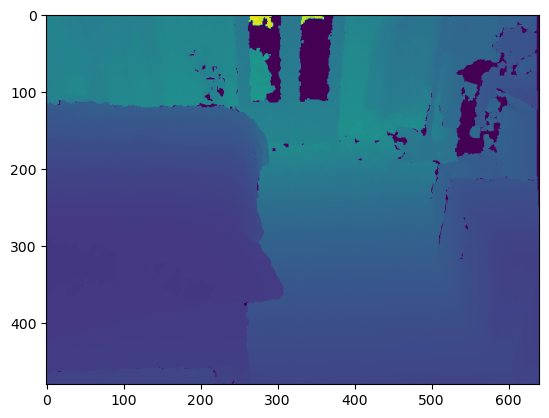

In [68]:
plt.imshow(raw_depth_map)

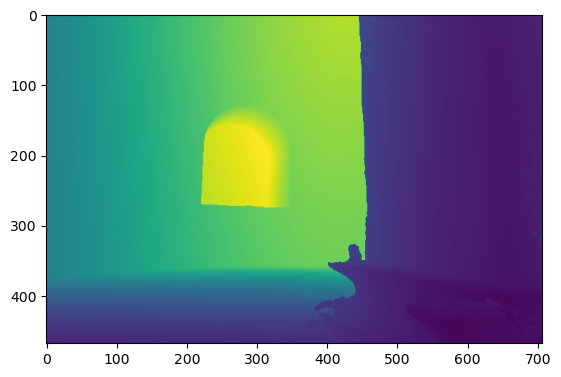

In [59]:
scale = 0.1
new_depth = np.array(
            Image.fromarray(depth, mode="F").resize(
                (int(depth.shape[1]*scale), int(depth.shape[0]*scale)), resample=Image.Resampling.NEAREST
            )
)
plt.imshow(new_depth)

In [80]:
new_depth.shape

(468, 707)

In [83]:
new_rgb.shape

(468, 707, 3)

In [82]:
new_rgb = np.array(
            Image.fromarray(rgb).resize(
                (int(rgb.shape[1]*scale), int(rgb.shape[0]*scale)), resample=Image.Resampling.BICUBIC
            )
        )

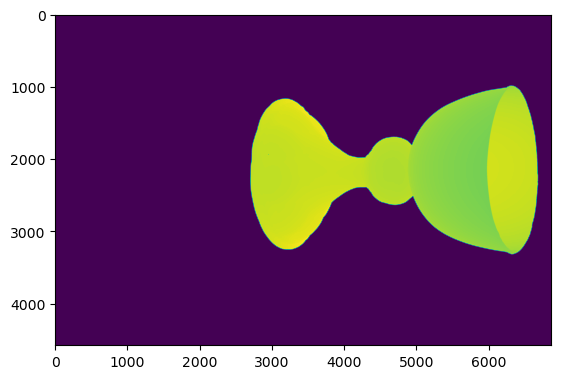

In [7]:
plt.imshow(depth)

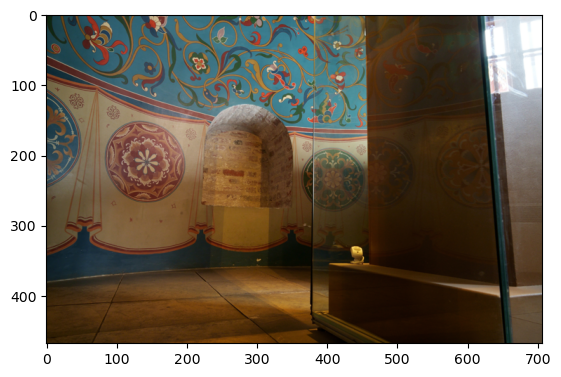

In [78]:
plt.imshow(new_rgb)

In [8]:
new_depth

array([[2.0809257 , 2.083702  , 2.0864863 , ..., 0.88335884, 0.8846025 ,
        0.8853978 ],
       [2.0808845 , 2.0836291 , 2.086381  , ..., 0.8834253 , 0.8846616 ,
        0.8854272 ],
       [2.0808609 , 2.0835562 , 2.0862865 , ..., 0.88349175, 0.8847205 ,
        0.8854567 ],
       ...,
       [0.93596095, 0.9354732 , 0.9350617 , ..., 0.6735197 , 0.6738045 ,
        0.6740991 ],
       [0.9344986 , 0.9341501 , 0.9340527 , ..., 0.6732829 , 0.67356765,
        0.67390424],
       [0.9334236 , 0.93317115, 0.9329975 , ..., 0.67304623, 0.6733308 ,
        0.67370963]], dtype=float32)

In [ ]:
def resize_depth(depth, rgb):
    new_depth = np.array(
        Image.fromarray(depth, mode="F").resize(
            (rgb.shape[1], rgb.shape[0]), resample=Image.Resampling.NEAREST
        )
    )
    return new_depth

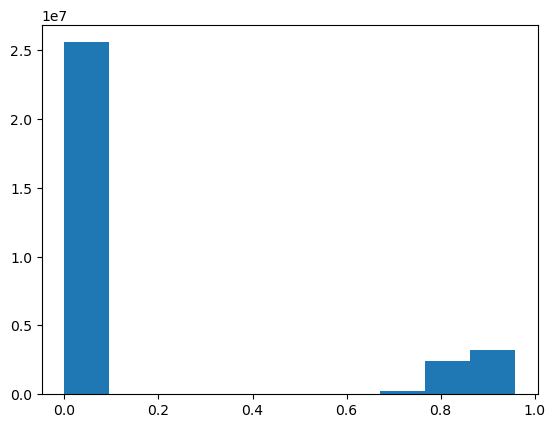

In [6]:
import matplotlib.pyplot as plt
plt.hist(depth.ravel());

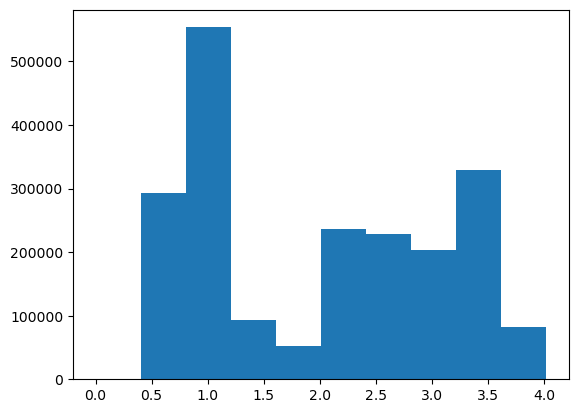

In [15]:
plt.hist(new_depth.ravel());

In [4]:
colmap = Colmap()
    images_txt = colmap.read_images_text(os.path.join(args.path_to_colmap,'dense/sparse/images.txt'))
    extrinsics = colmap.read_keylog(args.path_to_keylog)

    for extrinsic_id, extrisnic in tqdm(extrinsics.items()):
        render.set_rays_from_camera(load_colmap_camera(os.path.join(args.path_to_colmap,'dense/sparse/cameras.txt'), images_txt[extrinsic_id].camera_id))
        depthmap = render.render_to_camera(torch.tensor(extrisnic).float(), cull_back_faces=True)
        depthmap = depthmap['depthmap'].float().numpy()
        img_name = images_txt[extrinsic_id].name[:-4]+'.png'
        depthmap_file = os.path.join(args.save_path, img_name)
        Path(depthmap_file).parent.mkdir(exist_ok=True, parents=True)
        save_depthmap(depthmap_file, depthmap)

array([[1.17018799e+03, 0.00000000e+00, 6.47750000e+02, 0.00000000e+00],
       [0.00000000e+00, 1.17018799e+03, 4.83750000e+02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
for img_id, img in tqdm(dict(sorted(images_txt.items())).items()):
    img_name = images_txt[img_id].name[:-4]+'.png'
    depth_name = images_txt[img_id].name[:-4]+'.png'
    depth = unpack_float32(np.asarray((imageio.v2.imread(os.path.join(path_to_depths, depth_name)))))
    depth[np.isnan(depth)] = 0
    depth[np.isinf(depth)] = 0
    depth = o3d.geometry.Image(depth.copy())
    color = imageio.v2.imread(os.path.join(path_to_images, img_name))
    color = o3d.geometry.Image(color.copy())
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, convert_rgb_to_intensity=False, depth_scale=1, depth_trunc = 5001)
    rgbd_images.append(rgbd_image)

In [19]:
sys.path.append('/workspace/advtex_init_align/')
from advtex_init_align.utils.stream_utils import StreamReader

In [23]:
stream_reader = StreamReader('scannet', '/workspace/advtex_init_align/experiments/uofi/east_underchurch/Recv.stream')

stream_reader.read_stream()

# gt_rgbs = stream_reader.rgbs
# depth_maps = stream_reader.depth_maps

[daemon] Load data from 4 cameras in 177.74 s.


In [ ]:
# gt_rgbs = stream_reader.rgbs
# depth_maps = stream_reader.depth_maps